@@TODO image and description

In [1]:
%%html
<script>
MathJax = {
  tex: {
    inlineMath: [['$', '$']]
  },
  svg: {
    fontCache: 'global'
  }
};
</script>
<script type="text/javascript" id="MathJax-script" async
  src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-svg.js">
</script>
<script
src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.7/require.min.js"
integrity="sha512-J5ha2LF4Le+PBQnI5+xAVJDR+sZG9uSgroy4n/A6TLjNkvYQbqZA8WHZdaOvJ0HiKkBC9Frmvs10rFDSHKmveQ=="
crossorigin="anonymous"
referrerpolicy="no-referrer"></script>

In [2]:
import plotly.io as pio
pio.renderers.default = "notebook_connected+plotly_mimetype"

Neighbour-joining trees (NJT) are a useful tool for exploratory analysis of genetic population structure, which I've [written about recently](https://alimanfoo.github.io/2024/09/05/kenya-coluzzii-njt.html). Previously I've used [biotite](https://www.biotite-python.org/latest/index.html) to compute NJT for hundreds of individuals, but recently I was trying to build some bigger trees with thousands of individuals and things started to take a long time to run. I then learned of course that the canonical neighbour-joining algorithm is $O(n^3)$ meaning that speed of computation scales with the number of samples cubed. This happens because neighbour-joining is an iterative algorithm, where each iteration involves searching a distance matrix for the pair of nearest neighbours.

## Canonical algorithm

I spent some time looking at the biotite implementation which uses the canonical algorithm that fully searches the distance matrix at each iteration and is written in Cython. I saw a few opportunities to make the implementation more efficient by avoiding some unnecessary work. After a bit of prototyping I was fairly confident I could do an implementation of the canonical neighbour-joining algorithm using [numba](https://numba.pydata.org/) that was pretty fast. After a bit more tuning I managed to get around a 10x speedup over biotite. E.g., for a dataset of 3000 individuals, biotite took ~55s and my implementation took ~6s. I decided this was worth packaging and so created a [new Python packaged called "anjl"](https://alimanfoo.github.io/anjl/) which stands for "A neighbour-joining library". 

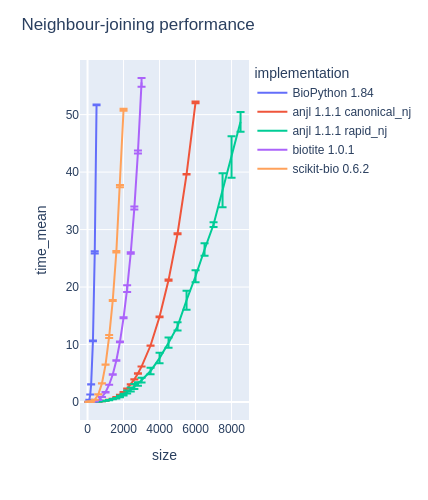

In [3]:
import pandas as pd
import plotly.express as px

df_results = pd.read_csv("results.csv")

df_plot = (
    df_results
    .groupby(["implementation", "size"])
    .agg(
        time_mean=("time", "mean"),
        time_std=("time", "std"),
    )
    .reset_index()
)

fig = px.line(
    df_plot,
    x="size",
    y="time_mean",
    error_y="time_std",
    width=800,
    height=500,
    color="implementation",
)
fig.update_layout(
    title="Neighbour-joining performance",
)
fig

## Rapid algorithm

I also read around a little and found a [paper by Martin Simonsen et al. from 2008](https://pure.au.dk/ws/files/19821675/rapidNJ.pdf) describing a rapid neighbour-joining algorithm which uses some heuristics to avoid doing a full search of the distance matrix in each iteration. While the worst case performance is still $O(n^3)$, in practice scaling is better. There is a [C++ implementation of the rapid algorithm](https://github.com/somme89/rapidNJ) but I'd really like something that I can call directly from Python. I added an implementation of neighbour-joining based on Simonsen's algorithm to `anjl`. Performance is substantially improved over the canonical algorithm, and the performance ratio increases with larger sample sizes, showing that scaling is indeed better.

## Plotting

@@TODO also factored out code for plotting unrooted tree.

## Numba lessons

I've used numba before but learned a few new things from this project.

### Boundscheck

@@TODO

### Wraparound

@@TODO

### Profiling 

@@TODO

## Mysteries / curiosities

There's a couple of curiosities that I didn't have time to bottom out.

1. Why is inner loop of canonical algorithm so much faster?

@@TODO

2. Why don't strategies for improving search suggested by Simonsen seem to matter?

@@TODO